<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/LoRA_DINO_Tool_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Grounding DINO
src: https://arxiv.org/pdf/2303.05499.pdf

In [1]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd /content/GroundingDINO
!pip install -q .
%cd ..

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 337 (delta 0), reused 1 (delta 0), pack-reused 336
Receiving objects: 100% (337/337), 12.36 MiB | 17.20 MiB/s, done.
Resolving deltas: 100% (162/162), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.2 MB/s eta 0:00:00
/content


In [2]:
# Grounding DINO
import os, sys
sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import torch
from huggingface_hub import hf_hub_download
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

load image

In [3]:
from PIL import Image
import requests
from io import BytesIO

# Load image 
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

os.makedirs('assets', exist_ok=True)
local_image_path = "assets/inpaint_demo.jpg"
# image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
image_url = "https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg"

download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)

Image downloaded from url: https://media.springernature.com/full/springer-static/image/art%3A10.1007%2Fs13304-020-00913-4/MediaObjects/13304_2020_913_Fig2_HTML.jpg and saved to: assets/inpaint_demo.jpg.


In [4]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    args.device = device
    model = build_model(args)
    
    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


tensor([[0.7548, 0.6707, 0.4883, 0.6498],
        [0.2702, 0.4200, 0.5374, 0.5584],
        [0.2698, 0.4960, 0.5367, 0.7119],
        [0.2597, 0.6305, 0.5168, 0.4465]])


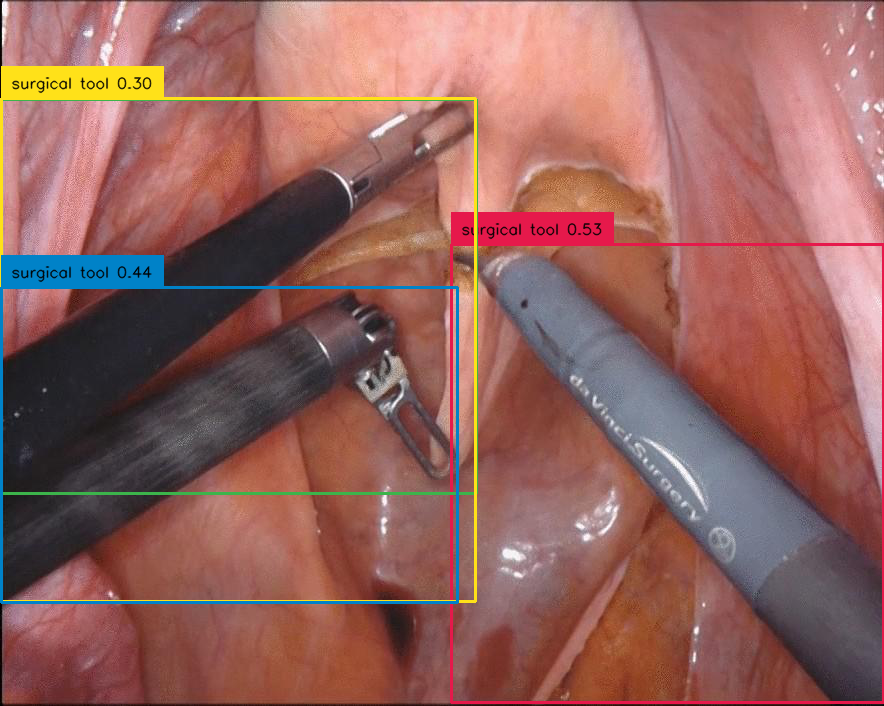

In [5]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model, 
      image=image, 
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )
  print(boxes)

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB 
  return annotated_frame, boxes 
  
annotated_frame, detected_boxes = detect(image, text_prompt="surgical tool", model=groundingdino_model)
Image.fromarray(annotated_frame)

Debugging:<br>
file1: /content/GroundingDINO/groundingdino/models/GroundingDINO/groundingdino.py <br>
file2: /content/GroundingDINO/groundingdino/util/inference.py

In [1]:
# Grounding DINO
import os, sys
sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import torch
from huggingface_hub import hf_hub_download
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


local_image_path = "assets/inpaint_demo.jpg"
image_source, image = load_image(local_image_path)


def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    args.device = device
    model = build_model(args)
    
    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model, 
      image=image, 
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )
  print(boxes)
  print(logits)
  # print(phrases)

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB 
  return annotated_frame, boxes 
  
annotated_frame, detected_boxes = detect(image, text_prompt="surgical tool", model=groundingdino_model)
# Image.fromarray(annotated_frame)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


mobarakkk torch.Size([6, 1, 900, 256]) torch.Size([6, 1, 900, 4]) torch.Size([1, 900, 256]) torch.Size([1, 5, 256])
tensor([[0.7548, 0.6707, 0.4883, 0.6498],
        [0.2702, 0.4200, 0.5374, 0.5584],
        [0.2698, 0.4960, 0.5367, 0.7119],
        [0.2597, 0.6305, 0.5168, 0.4465]])
tensor([0.5297, 0.4241, 0.3036, 0.4397])


In [3]:
groundingdino_model.class_embed[0]

ContrastiveEmbed()